In [107]:
%matplotlib inline
#some basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.display import display

#TODO: add your imports here
from elasticsearch import Elasticsearch
from matplotlib.lines import Line2D

#seting up some styles
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

experiment_name = "DITAS-Performance-Benchmark"

#getting data
from load import load_elastic,load_experiment,load_vmstat,load_rmstats
use_cache=False
load_from_disk = False

es = Elasticsearch(host="153.92.30.56",
                   http_auth=('admin', 'ditasmetrics'),
                   scheme="http",
                   port=50035)

In [108]:
to_download = [pd.Timestamp("2019-12-16")]
mon__cache_file="rmstats/rmstats_{}.csv".format(datetime.now().strftime("%d-%m-%Y"))
esData = load_elastic(False,True,mon__cache_file,es,to_download)

loading data from index *-2019-12-16


In [109]:
data_cache_file="{}_{}.data.csv".format(experiment_name,datetime.now().strftime("%d-%m-%Y"))
data = load_experiment(use_cache,True,data_cache_file)


experiment_dates =list(map(lambda x:pd.Timestamp(x),data['runDate'].unique()))
esData = load_rmstats()

vstat__cache_file="{}_{}.vmstat.csv".format(experiment_name,datetime.now().strftime("%d-%m-%Y"))
vsData = load_vmstat(use_cache,True,vstat__cache_file)

In [110]:
esData["timestamp"] = pd.to_datetime(esData["@timestamp"],format='%Y-%m-%dT%H:%M:%S.%f',utc=True)
esData["timestamp"] = esData["timestamp"].dt.ceil(freq='s')  
esData["timestamp"] = esData["timestamp"].dt.tz_convert(None)

data["timestamp"] = data["startTime"]+data["offset"].astype(int).apply(lambda x:pd.Timedelta(seconds=x))
vsData["timestamp"] = vsData["timestamp"] -pd.Timedelta(seconds=3600)

In [111]:
def plot(subjects,name,offset,statistics,show_vrrl=True):  
    #select the exp we want to look at
    exp = data[data["experiment"].isin(subjects)]
    #remove data not from that exp
    EStart,EEnd = exp["timestamp"].min(),exp["timestamp"].max()
    expVMStats = vsData[vsData["timestamp"].between(EStart,EEnd)]
    expRMStats = esData[esData["timestamp"].between(EStart,EEnd)]
    
    #remove timeout errors (timeout of client is 120)
    exp = exp[exp["response-time"] < 120]

    #create a copy to work with and normilize the time across each view
    exp = exp.copy()
    expVMStats = expVMStats.copy()
    expRMStats = expRMStats.copy()
    exp["ETime"] = exp["timestamp"]-EStart
    expVMStats["ETime"] = expVMStats["timestamp"]-EStart
    expRMStats["ETime"] = expRMStats["timestamp"]-EStart+pd.Timedelta(seconds=offset)

    exp["ETime"] = exp["ETime"].apply(lambda x:x.total_seconds())
    expVMStats["ETime"] = expVMStats["ETime"].apply(lambda x:x.total_seconds())
    expRMStats["ETime"] = expRMStats["ETime"].apply(lambda x:x.total_seconds())

    
    exp["sliceID"] = np.round(exp["ETime"]/slice_size)
    client_view = exp.groupby("sliceID")["response-time","size"].agg(["min","max","mean","sum"])
    
    if len(expRMStats) > 0:
        expRMStats["sliceID"] = np.round(expRMStats["ETime"]/slice_size)
        expRMStats["requestTime_sec"] = np.round(expRMStats["request.requestTime"]/1000000000,2)
        vdc_view = expRMStats.groupby("sliceID")["requestTime_sec","response.length"].agg(["min","max","mean","sum"])
    else:
        vdc_view = pd.DataFrame([],columns=pd.MultiIndex(levels=[['requestTime_sec', 'response.length'], ['min', 'max', 'mean', 'sum']],
              codes=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]]))

    expVMStats["sliceID"] = np.round(expVMStats["ETime"]/slice_size)

    
    
    mashine_view = expVMStats.groupby("sliceID")[["cpu_user","free"]].mean()
    
    fig = plt.figure(figsize=(15,6))
    gs = fig.add_gridspec(ncols=3, nrows=1)
    plt.suptitle("{} Results".format(name), fontsize=16,y=0.99)
    ax = fig.add_subplot(gs[0, 0:2])
    ax2 = ax.twinx()
    ax.plot(client_view["response-time"]["mean"],label="CRRL",color=colors["CRRL"],zorder=2)
    ax.fill_between(client_view.index,client_view["response-time"]["min"],client_view["response-time"]["max"],color=colors["CRRL"],alpha=0.4,zorder=1)
    
    if len(vdc_view) > 0 and show_vrrl:
        ax.plot(vdc_view["requestTime_sec"]["mean"],label="VRRL",color=colors["VRRL"],zorder=2)
        ax.fill_between(vdc_view.index,vdc_view["requestTime_sec"]["min"],vdc_view["requestTime_sec"]["max"],color=colors["VRRL"],alpha=0.4,zorder=1)
    
    ax.set_title("Client-View")
    ax2.plot(client_view["size"]["mean"]/slice_size,label="Throughput",color=colors["Thr"],zorder=2)
    ax.set_ylabel("Request-Response-Time [s]")
    ax2.set_ylabel("Throughput [bytes/s]")
    ax.set_xlabel("Time [s]")
    ax.set_xticklabels([""])
    legendNames = ["CRRL","VRRL","Throughput"]

    legendShapes = [
            Line2D([0], [0], color=colors["CRRL"], lw=2),
            Line2D([0], [0], color=colors["VRRL"], lw=2),
            Line2D([0], [0], color=colors["Thr"], lw=2)
        ]
    ax.legend(legendShapes, legendNames, fancybox=True, shadow=True)
    ax = fig.add_subplot(gs[0, 2])

    ax2 = ax.twinx()
    ax2.fill_between(mashine_view.index,mashine_view["free"],np.zeros(len(mashine_view["free"])),alpha=0.5,zorder=10,color=colors["MEM"])
    sns.lineplot(mashine_view.index,mashine_view["free"],zorder=10,color=colors["MEM"],ax=ax2)
    sns.lineplot(x=mashine_view.index,y=mashine_view["cpu_user"],ax=ax,color=colors["CPU"],zorder=1,linewidth=2)
    ax.set_ylabel("CPU Usage [%]")
    ax2.set_ylabel("Memory Usage [MB]")
    ax.set_title("VDC-View")
    ax.set_xlabel("Time [s]")
    ax.set_xticklabels([""])
    plt.tight_layout()
    fig.savefig("images/{}.pdf".format(name), bbox_inches="tight")
    fig.savefig("images/{}.png".format(name), bbox_inches="tight")
    if len(vdc_view) > 0:
        transport_latency = exp["response-time"].mean()-expRMStats["requestTime_sec"].mean()
        rmMean = expRMStats["requestTime_sec"].mean()
        p90 = expRMStats["requestTime_sec"].quantile(0.9)
    else:
        transport_latency = float("nan")
        rmMean = float("nan")
        p90 = float("nan")
    
    
    
    df = [name,np.round(transport_latency,2),exp["response-time"].mean(),exp["response-time"].quantile(0.9),rmMean,p90]
    if (statistics is None):
        statistics = [df]
    else:
        statistics.append(df)
    return statistics

In [112]:
colors = {
    "CRRL":"#448ee4",
    "VRRL":"#25a36f",
    "MEM":"#89a203",
    "CPU":"#000000",
    "Thr":"#555555"
}

experiments = {
    "B3":(["B4A","B4B"],330),
    "B1":(["B1"],360),
    "B8":(["B9"],320),
    "B9":(["B10"],360),
    "B7":(["B8"],360)
}

slice_size = 60

,name,Mean TL,Mean CRRL,p90 CRRL,Mean VRRL,p90 VRRL
0,B3,0.37,9.206901,13.36830,8.838386,12.706
1,B1,0.21,11.683438,18.65126,11.469177,18.317
2,B8,NaN,5.762641,6.82930,NaN,NaN
3,B9,0.43,9.423364,12.64067,8.997540,12.095


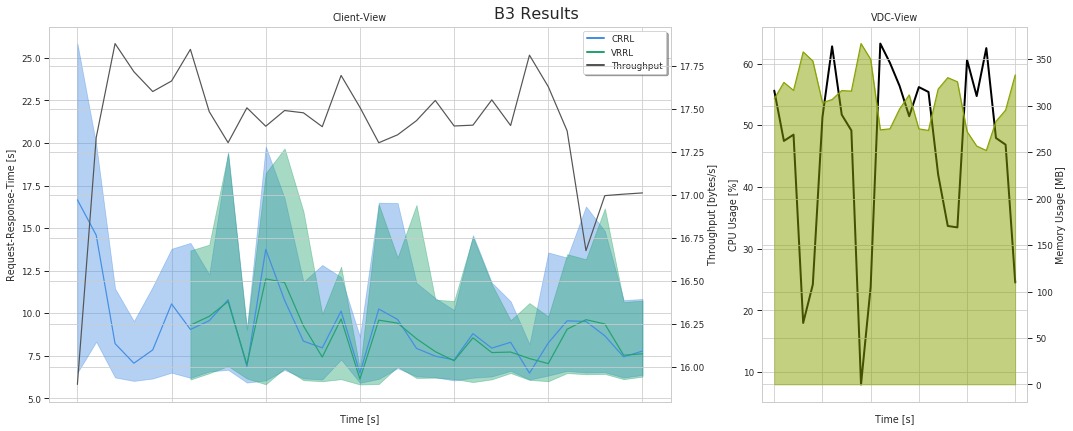

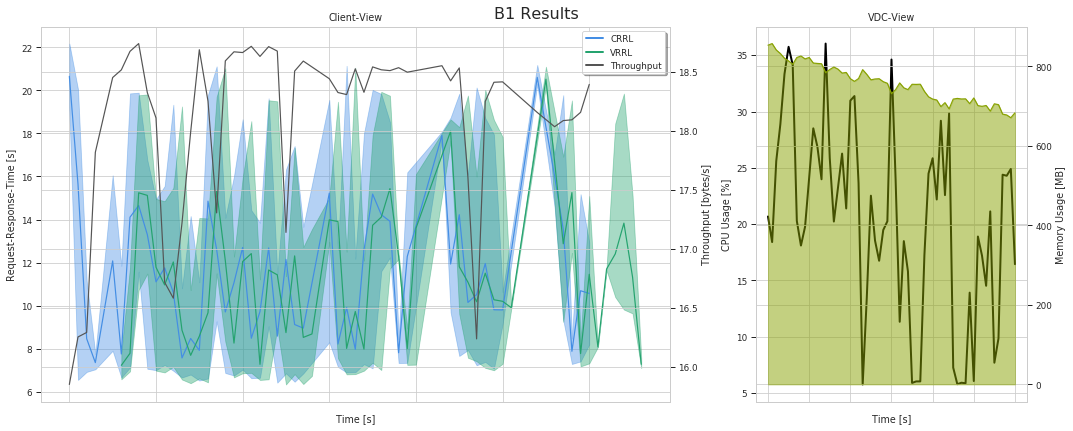

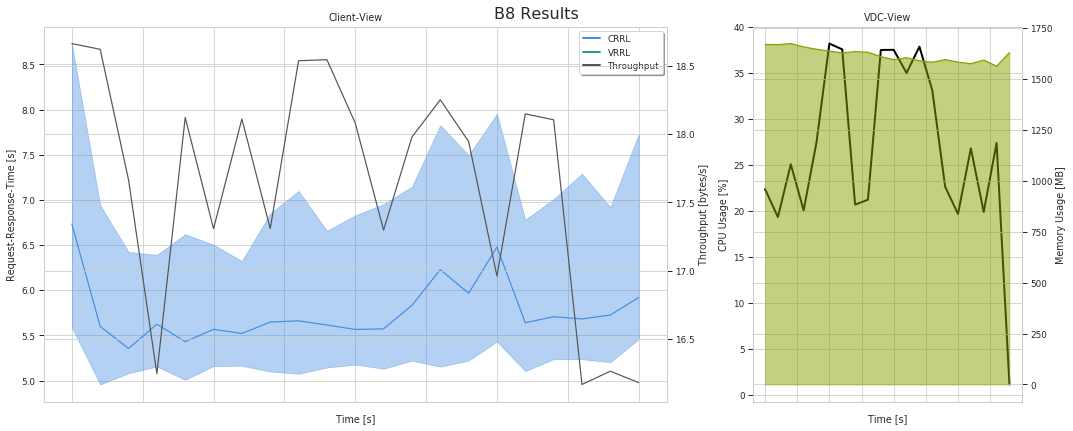

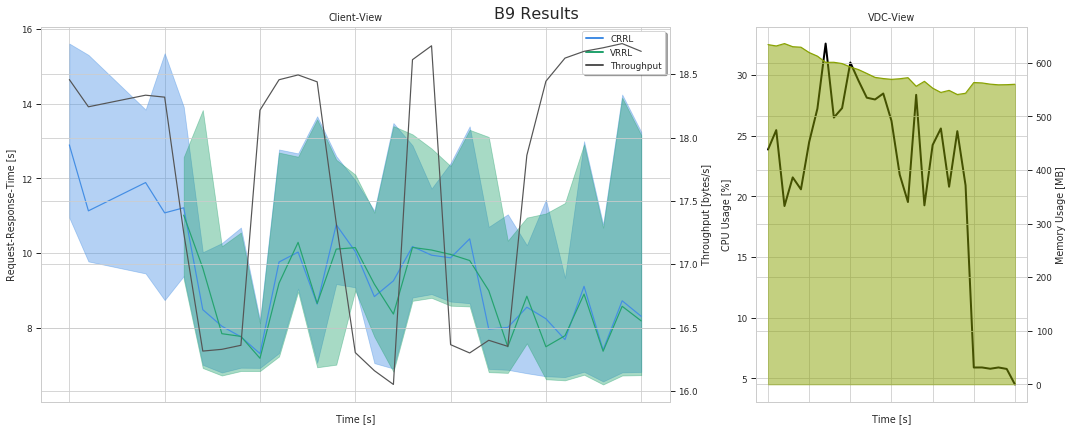

In [113]:
statistics = None
for s in experiments:
    statistics = plot(experiments[s][0],s,experiments[s][1],statistics)
statistics = pd.DataFrame(statistics,columns=["name","Mean TL","Mean CRRL","p90 CRRL","Mean VRRL","p90 VRRL"])
statistics

,name,Mean TL,Mean CRRL,p90 CRRL,Mean VRRL,p90 VRRL
0,B3,0.37,9.206900950871633,13.3683,8.838385826771654,12.706
1,B1,0.21,11.683438021978024,18.65126,11.46917748917749,18.317
2,B8,0.99,10.311114285714286,16.249019999999998,9.325777777777779,15.924
3,B9,0.43,9.423364285714287,12.640669999999998,8.997539682539683,12.094999999999999
4,B7,nan,5.7626408945686896,6.8293,nan,nan
